In [1]:
import copy
import json
import time

import awkward as ak
import correctionlib
import hist
import matplotlib.pyplot as plt
import numpy as np
from awkward._nplikes.dispatch import nplike_of_obj
from awkward._nplikes.virtual import VirtualArray
from coffea import processor
from coffea.analysis_tools import PackedSelection
from coffea.nanoevents import NanoAODSchema, NanoEventsFactory
from coffea.nanoevents.mapping.uproot import UprootSourceMapping
from matplotlib import pyplot as plt

import utils  # contains code for bookkeeping and cosmetics, as well as some boilerplate

NanoAODSchema.warn_missing_crossrefs = False
USE_INFERENCE = True
UprootSourceMapping._debug = False

/home/iason/Dropbox/work/coffea_dev/coffea/src/coffea/nanoevents/schemas/fcc.py:5: FutureWarning: In version 2025.1.0 (target date: 2024-12-31 11:59:59-06:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import vector


In [2]:
class TtbarAnalysis(processor.ProcessorABC):
    def __init__(self, use_inference, use_triton):
        # initialize dictionary of hists for signal and control region
        self.hist_dict = {}
        for region in ["4j1b", "4j2b"]:
            self.hist_dict[region] = (
                hist.Hist.new.Reg(
                    utils.config["global"]["NUM_BINS"],
                    utils.config["global"]["BIN_LOW"],
                    utils.config["global"]["BIN_HIGH"],
                    name="observable",
                    label="observable [GeV]",
                )
                .StrCat([], name="process", label="Process", growth=True)
                .StrCat([], name="variation", label="Systematic variation", growth=True)
                .Weight()
            )

        self.cset = correctionlib.CorrectionSet.from_file("corrections.json")
        self.use_inference = use_inference

        # set up attributes only needed if USE_INFERENCE=True
        if self.use_inference:
            # initialize dictionary of hists for ML observables
            self.ml_hist_dict = {}
            for i in range(len(utils.config["ml"]["FEATURE_NAMES"])):
                self.ml_hist_dict[utils.config["ml"]["FEATURE_NAMES"][i]] = (
                    hist.Hist.new.Reg(
                        utils.config["global"]["NUM_BINS"],
                        utils.config["ml"]["BIN_LOW"][i],
                        utils.config["ml"]["BIN_HIGH"][i],
                        name="observable",
                        label=utils.config["ml"]["FEATURE_DESCRIPTIONS"][i],
                    )
                    .StrCat([], name="process", label="Process", growth=True)
                    .StrCat([], name="variation", label="Systematic variation", growth=True)
                    .Weight()
                )

            self.use_triton = use_triton

    def only_do_IO(self, events):
        for branch in utils.config["benchmarking"]["IO_BRANCHES"][utils.config["benchmarking"]["IO_FILE_PERCENT"]]:
            if "_" in branch:
                split = branch.split("_")
                object_type = split[0]
                property_name = "_".join(split[1:])
                ak.materialize(events[object_type][property_name])
            else:
                ak.materialize(events[branch])
        return {"hist": {}}

    def process(self, events):
        if utils.config["benchmarking"]["DISABLE_PROCESSING"]:
            # IO testing with no subsequent processing
            return self.only_do_IO(events)

        # create copies of histogram objects
        hist_dict = copy.deepcopy(self.hist_dict)
        if self.use_inference:
            ml_hist_dict = copy.deepcopy(self.ml_hist_dict)

        process = events.metadata["process"]  # "ttbar" etc.
        variation = events.metadata["variation"]  # "nominal" etc.

        # normalization for MC
        x_sec = events.metadata["xsec"]
        nevts_total = events.metadata["nevts"]
        lumi = 3378  # /pb
        if process != "data":
            xsec_weight = x_sec * lumi / nevts_total
        else:
            xsec_weight = 1

        # setup triton gRPC client or xgboost
        if self.use_inference:
            if self.use_triton:
                triton_client = utils.clients.get_triton_client(utils.config["ml"]["TRITON_URL"])
            else:
                if utils.ml.model_even is None:
                    utils.ml.load_models()

        #### systematics
        # jet energy scale / resolution systematics
        # need to adjust schema to instead use coffea add_systematic feature, especially for ServiceX
        # cannot attach pT variations to events.jet, so attach to events directly
        # and subsequently scale pT by these scale factors
        events["pt_scale_up"] = 1.03
        events["pt_res_up"] = utils.systematics.jet_pt_resolution(events.Jet.pt)

        syst_variations = ["nominal"]
        jet_kinematic_systs = ["pt_scale_up", "pt_res_up"]
        event_systs = [f"btag_var_{i}" for i in range(4)]
        if process == "wjets":
            event_systs.append("scale_var")

        # Only do systematics for nominal samples, e.g. ttbar__nominal
        if variation == "nominal":
            syst_variations.extend(jet_kinematic_systs)
            syst_variations.extend(event_systs)

        # for pt_var in pt_variations:
        for syst_var in syst_variations:
            ### event selection
            # very very loosely based on https://arxiv.org/abs/2006.13076

            # Note: This creates new objects, distinct from those in the 'events' object
            elecs = events.Electron
            muons = events.Muon
            jets = events.Jet
            if syst_var in jet_kinematic_systs:
                # Replace jet.pt with the adjusted values
                jets["pt"] = jets.pt * events[syst_var]

            electron_reqs = (elecs.pt > 30) & (np.abs(elecs.eta) < 2.1) & (elecs.cutBased == 4) & (elecs.sip3d < 4)
            muon_reqs = (
                (muons.pt > 30)
                & (np.abs(muons.eta) < 2.1)
                & (muons.tightId)
                & (muons.sip3d < 4)
                & (muons.pfRelIso04_all < 0.15)
            )
            jet_reqs = (jets.pt > 30) & (np.abs(jets.eta) < 2.4) & (jets.isTightLeptonVeto)

            # Only keep objects that pass our requirements
            elecs = elecs[electron_reqs]
            muons = muons[muon_reqs]
            jets = jets[jet_reqs]

            if self.use_inference:
                even = events.event % 2 == 0  # whether events are even/odd

            B_TAG_THRESHOLD = 0.5

            ######### Store boolean masks with PackedSelection ##########
            selections = PackedSelection(dtype="uint64")
            # Basic selection criteria
            selections.add("exactly_1l", (ak.num(elecs) + ak.num(muons)) == 1)
            selections.add("atleast_4j", ak.num(jets) >= 4)
            selections.add("exactly_1b", ak.sum(jets.btagCSVV2 > B_TAG_THRESHOLD, axis=1) == 1)
            selections.add("atleast_2b", ak.sum(jets.btagCSVV2 > B_TAG_THRESHOLD, axis=1) >= 2)
            # Complex selection criteria
            selections.add("4j1b", selections.all("exactly_1l", "atleast_4j", "exactly_1b"))
            selections.add("4j2b", selections.all("exactly_1l", "atleast_4j", "atleast_2b"))

            for region in ["4j1b", "4j2b"]:
                region_selection = selections.all(region)
                region_jets = jets[region_selection]
                region_elecs = elecs[region_selection]
                region_muons = muons[region_selection]
                region_weights = np.ones(len(region_jets)) * xsec_weight
                if self.use_inference:
                    region_even = even[region_selection]

                if region == "4j1b":
                    observable = ak.sum(region_jets.pt, axis=-1)

                elif region == "4j2b":
                    # reconstruct hadronic top as bjj system with largest pT
                    trijet = ak.combinations(region_jets, 3, fields=["j1", "j2", "j3"])  # trijet candidates
                    trijet["p4"] = trijet.j1 + trijet.j2 + trijet.j3  # calculate four-momentum of tri-jet system
                    trijet["max_btag"] = np.maximum(
                        trijet.j1.btagCSVV2,
                        np.maximum(trijet.j2.btagCSVV2, trijet.j3.btagCSVV2),
                    )
                    trijet = trijet[trijet.max_btag > B_TAG_THRESHOLD]  # at least one-btag in trijet candidates
                    # pick trijet candidate with largest pT and calculate mass of system
                    trijet_mass = trijet["p4"][ak.argmax(trijet.p4.pt, axis=1, keepdims=True)].mass
                    observable = ak.flatten(trijet_mass)

                    if sum(region_selection) == 0:
                        continue

                    if self.use_inference:
                        features, perm_counts = utils.ml.get_features(
                            region_jets,
                            region_elecs,
                            region_muons,
                            max_n_jets=utils.config["ml"]["MAX_N_JETS"],
                        )
                        even_perm = np.repeat(region_even, perm_counts)

                        # calculate ml observable
                        if self.use_triton:
                            results = utils.ml.get_inference_results_triton(
                                features,
                                even_perm,
                                triton_client,
                                utils.config["ml"]["MODEL_NAME"],
                                utils.config["ml"]["MODEL_VERSION_EVEN"],
                                utils.config["ml"]["MODEL_VERSION_ODD"],
                            )

                        else:
                            results = utils.ml.get_inference_results_local(
                                features,
                                even_perm,
                                utils.ml.model_even,
                                utils.ml.model_odd,
                            )

                        results = ak.unflatten(results, perm_counts)
                        features = ak.flatten(
                            ak.unflatten(features, perm_counts)[
                                ak.from_regular(ak.argmax(results, axis=1)[:, np.newaxis])
                            ]
                        )
                syst_var_name = f"{syst_var}"
                # Break up the filling into event weight systematics and object variation systematics
                if syst_var in event_systs:
                    for i_dir, direction in enumerate(["up", "down"]):
                        # Should be an event weight systematic with an up/down variation
                        if syst_var.startswith("btag_var"):
                            i_jet = int(syst_var.rsplit("_", 1)[-1])  # Kind of fragile
                            wgt_variation = self.cset["event_systematics"].evaluate(
                                "btag_var", direction, region_jets.pt[:, i_jet]
                            )
                        elif syst_var == "scale_var":
                            # The pt array is only used to make sure the output array has the correct shape
                            wgt_variation = self.cset["event_systematics"].evaluate(
                                "scale_var", direction, region_jets.pt[:, 0]
                            )
                        syst_var_name = f"{syst_var}_{direction}"
                        hist_dict[region].fill(
                            observable=observable,
                            process=process,
                            variation=syst_var_name,
                            weight=region_weights * wgt_variation,
                        )
                        if region == "4j2b" and self.use_inference:
                            for i in range(len(utils.config["ml"]["FEATURE_NAMES"])):
                                ml_hist_dict[utils.config["ml"]["FEATURE_NAMES"][i]].fill(
                                    observable=features[..., i],
                                    process=process,
                                    variation=syst_var_name,
                                    weight=region_weights * wgt_variation,
                                )
                else:
                    # Should either be 'nominal' or an object variation systematic
                    if variation != "nominal":
                        # This is a 2-point systematic, e.g. ttbar__scaledown, ttbar__ME_var, etc.
                        syst_var_name = variation
                    hist_dict[region].fill(
                        observable=observable,
                        process=process,
                        variation=syst_var_name,
                        weight=region_weights,
                    )
                    if region == "4j2b" and self.use_inference:
                        for i in range(len(utils.config["ml"]["FEATURE_NAMES"])):
                            ml_hist_dict[utils.config["ml"]["FEATURE_NAMES"][i]].fill(
                                observable=features[..., i],
                                process=process,
                                variation=syst_var_name,
                                weight=region_weights,
                            )

        output = {
            "nevents": {events.metadata["dataset"]: len(events)},
            "hist_dict": hist_dict,
        }
        if self.use_inference:
            output["ml_hist_dict"] = ml_hist_dict

        return output

    def postprocess(self, accumulator):
        return accumulator

In [3]:
%%time

# events = NanoEventsFactory.from_root({"cmsopendata2015_ttbar_19981_PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext4-v1_80000_0007.root": "Events"},
#      mode="eager",
#      schemaclass=NanoAODSchema,
#      metadata={'dataset': 'ttbar__nominal', 'process': 'ttbar', 'variation': 'nominal', 'nevts': 276079127, 'xsec': 729.84}
#     ).events()


# def virtualize(array, form_key):
#     def generate():
#         print(f"Generating {form_key}")
#         return array

#     return VirtualArray(nplike_of_obj(array), array.shape, array.dtype, generate)


# def make_events(file, schemaclass=NanoAODSchema):
#     access_log = []
#     events = NanoEventsFactory.from_root(
#         {file: "Events"},
#         mode="eager",
#         schemaclass=schemaclass,
#         metadata={
#             "dataset": "ttbar__nominal",
#             "process": "ttbar",
#             "variation": "nominal",
#             "nevts": 276079127,
#             "xsec": 729.84,
#         },
#     ).events()
#     behavior = events.behavior
#     attrs = events.attrs
#     form, length, container = ak.to_buffers(events)
#     new_form = events.layout.form_with_key_path()
#     new_container = {}
#     for old_key, new_key in zip(form.expected_from_buffers().keys(), new_form.expected_from_buffers().keys()):
#         new_container[new_key] = container[old_key]
#     with open("form.json", "w") as f:
#         json.dump(form.to_dict(), f, indent=2)
#     virtual_container = {key: virtualize(buffer, key) for key, buffer in new_container.items()}
#     events = ak.from_buffers(new_form, length, virtual_container, behavior=behavior)
#     # events.attrs["@original_array"] = events
#     print("-" * 100)
#     return events, access_log


def make_events(file, schemaclass=NanoAODSchema):
    access_log = []
    events = NanoEventsFactory.from_root(
        {file: "Events"},
        mode="virtual",
        schemaclass=schemaclass,
        metadata={
            "dataset": "ttbar__nominal",
            "process": "ttbar",
            "variation": "nominal",
            "nevts": 276079127,
            "xsec": 729.84,
        },
        access_log=access_log,
    ).events()
    access_log.append("-" * 100)
    return events, access_log


events, access_log = make_events(
    "cmsopendata2015_ttbar_19981_PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext4-v1_80000_0007.root"
)
access_log

CPU times: user 3.88 s, sys: 1.02 s, total: 4.9 s
Wall time: 4.81 s


['nFsrPhoton',
 'nFatJet',
 'nCorrT1METJet',
 'nTau',
 'nGenDressedLepton',
 'LHEReweightingWeight',
 'nOtherPV',
 'nGenVisTau',
 'PSWeight',
 'nSoftActivityJet',
 'LHEPdfWeight',
 'nLHEPart',
 'nSV',
 'nMuon',
 'nPhoton',
 'nGenIsolatedPhoton',
 'nJet',
 'Jet_muonIdx1',
 'nMuon',
 'Jet_muonIdx2',
 'nMuon',
 'Jet_electronIdx1',
 'nElectron',
 'Jet_electronIdx2',
 'nElectron',
 'nGenPart',
 'nGenPart',
 'GenPart_genPartIdxMother',
 'nGenPart',
 'nGenPart',
 'GenPart_genPartIdxMother',
 'nGenPart',
 'GenPart_pdgId',
 'nGenPart',
 'GenPart_genPartIdxMother',
 'nGenPart',
 'GenPart_pdgId',
 'nElectron',
 'nGenJetAK8',
 'LHEScaleWeight',
 'nGenJet',
 '----------------------------------------------------------------------------------------------------']

In [4]:
processor_instance = TtbarAnalysis(use_inference=USE_INFERENCE, use_triton=False)
t0 = time.monotonic()
all_histograms = processor_instance.process(events)
exec_time = time.monotonic() - t0
print(f"\nexecution took {exec_time:.2f} seconds")
access_log


execution took 4.70 seconds


['nFsrPhoton',
 'nFatJet',
 'nCorrT1METJet',
 'nTau',
 'nGenDressedLepton',
 'LHEReweightingWeight',
 'nOtherPV',
 'nGenVisTau',
 'PSWeight',
 'nSoftActivityJet',
 'LHEPdfWeight',
 'nLHEPart',
 'nSV',
 'nMuon',
 'nPhoton',
 'nGenIsolatedPhoton',
 'nJet',
 'Jet_muonIdx1',
 'nMuon',
 'Jet_muonIdx2',
 'nMuon',
 'Jet_electronIdx1',
 'nElectron',
 'Jet_electronIdx2',
 'nElectron',
 'nGenPart',
 'nGenPart',
 'GenPart_genPartIdxMother',
 'nGenPart',
 'nGenPart',
 'GenPart_genPartIdxMother',
 'nGenPart',
 'GenPart_pdgId',
 'nGenPart',
 'GenPart_genPartIdxMother',
 'nGenPart',
 'GenPart_pdgId',
 'nElectron',
 'nGenJetAK8',
 'LHEScaleWeight',
 'nGenJet',
 '----------------------------------------------------------------------------------------------------',
 'nJet',
 'nElectron',
 'Electron_pt',
 'Electron_eta',
 'Electron_cutBased',
 'Electron_sip3d',
 'nMuon',
 'Muon_pt',
 'Muon_eta',
 'Muon_tightId',
 'Muon_sip3d',
 'Muon_pfRelIso04_all',
 'Jet_pt',
 'Jet_eta',
 'Jet_jetId',
 'event',
 'Jet_b

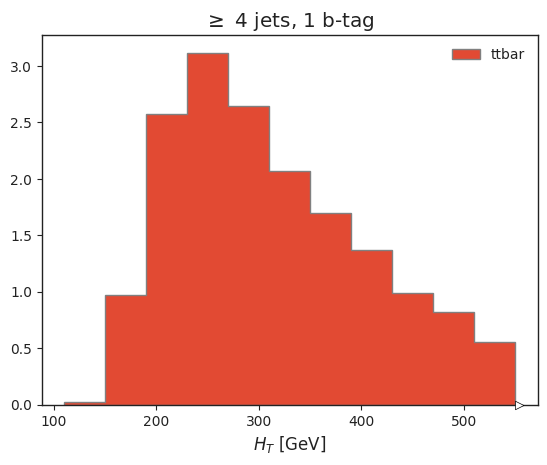

In [5]:
import utils.plotting  # noqa: E402

utils.plotting.set_style()

all_histograms["hist_dict"]["4j1b"][120j :: hist.rebin(2), :, "nominal"].stack("process")[::-1].plot(
    stack=True, histtype="fill", linewidth=1, edgecolor="grey"
)
plt.legend(frameon=False)
plt.title(r"$\geq$ 4 jets, 1 b-tag")
plt.xlabel(r"$H_T$ [GeV]");

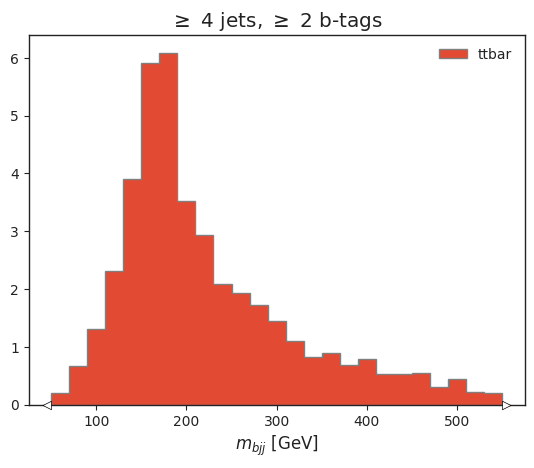

In [6]:
all_histograms["hist_dict"]["4j2b"][:, :, "nominal"].stack("process")[::-1].plot(
    stack=True, histtype="fill", linewidth=1, edgecolor="grey"
)
plt.legend(frameon=False)
plt.title(r"$\geq$ 4 jets, $\geq$ 2 b-tags")
plt.xlabel(r"$m_{bjj}$ [GeV]");

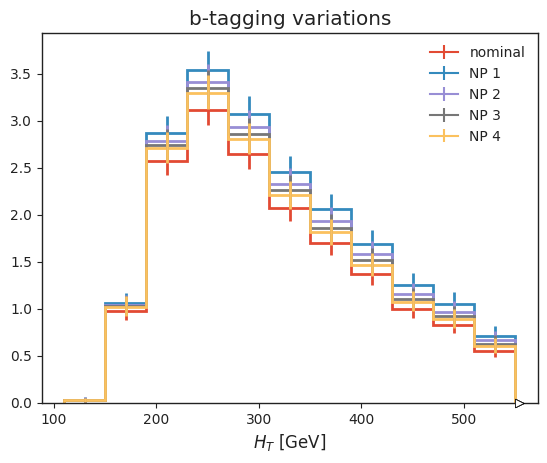

In [7]:
# b-tagging variations
all_histograms["hist_dict"]["4j1b"][120j :: hist.rebin(2), "ttbar", "nominal"].plot(label="nominal", linewidth=2)
all_histograms["hist_dict"]["4j1b"][120j :: hist.rebin(2), "ttbar", "btag_var_0_up"].plot(label="NP 1", linewidth=2)
all_histograms["hist_dict"]["4j1b"][120j :: hist.rebin(2), "ttbar", "btag_var_1_up"].plot(label="NP 2", linewidth=2)
all_histograms["hist_dict"]["4j1b"][120j :: hist.rebin(2), "ttbar", "btag_var_2_up"].plot(label="NP 3", linewidth=2)
all_histograms["hist_dict"]["4j1b"][120j :: hist.rebin(2), "ttbar", "btag_var_3_up"].plot(label="NP 4", linewidth=2)
plt.legend(frameon=False)
plt.xlabel("$H_T$ [GeV]")
plt.title("b-tagging variations");

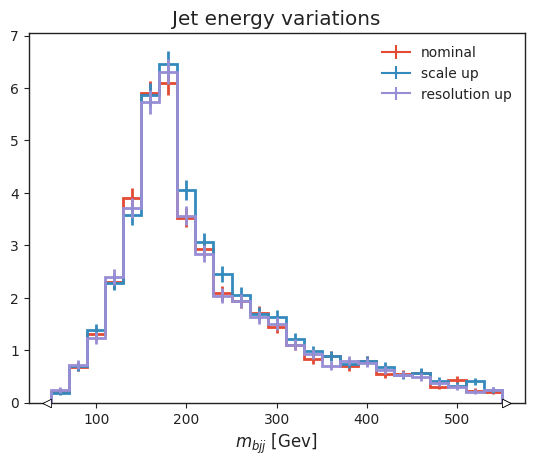

In [8]:
# jet energy scale variations
all_histograms["hist_dict"]["4j2b"][:, "ttbar", "nominal"].plot(label="nominal", linewidth=2)
all_histograms["hist_dict"]["4j2b"][:, "ttbar", "pt_scale_up"].plot(label="scale up", linewidth=2)
all_histograms["hist_dict"]["4j2b"][:, "ttbar", "pt_res_up"].plot(label="resolution up", linewidth=2)
plt.legend(frameon=False)
plt.xlabel("$m_{bjj}$ [Gev]")
plt.title("Jet energy variations");

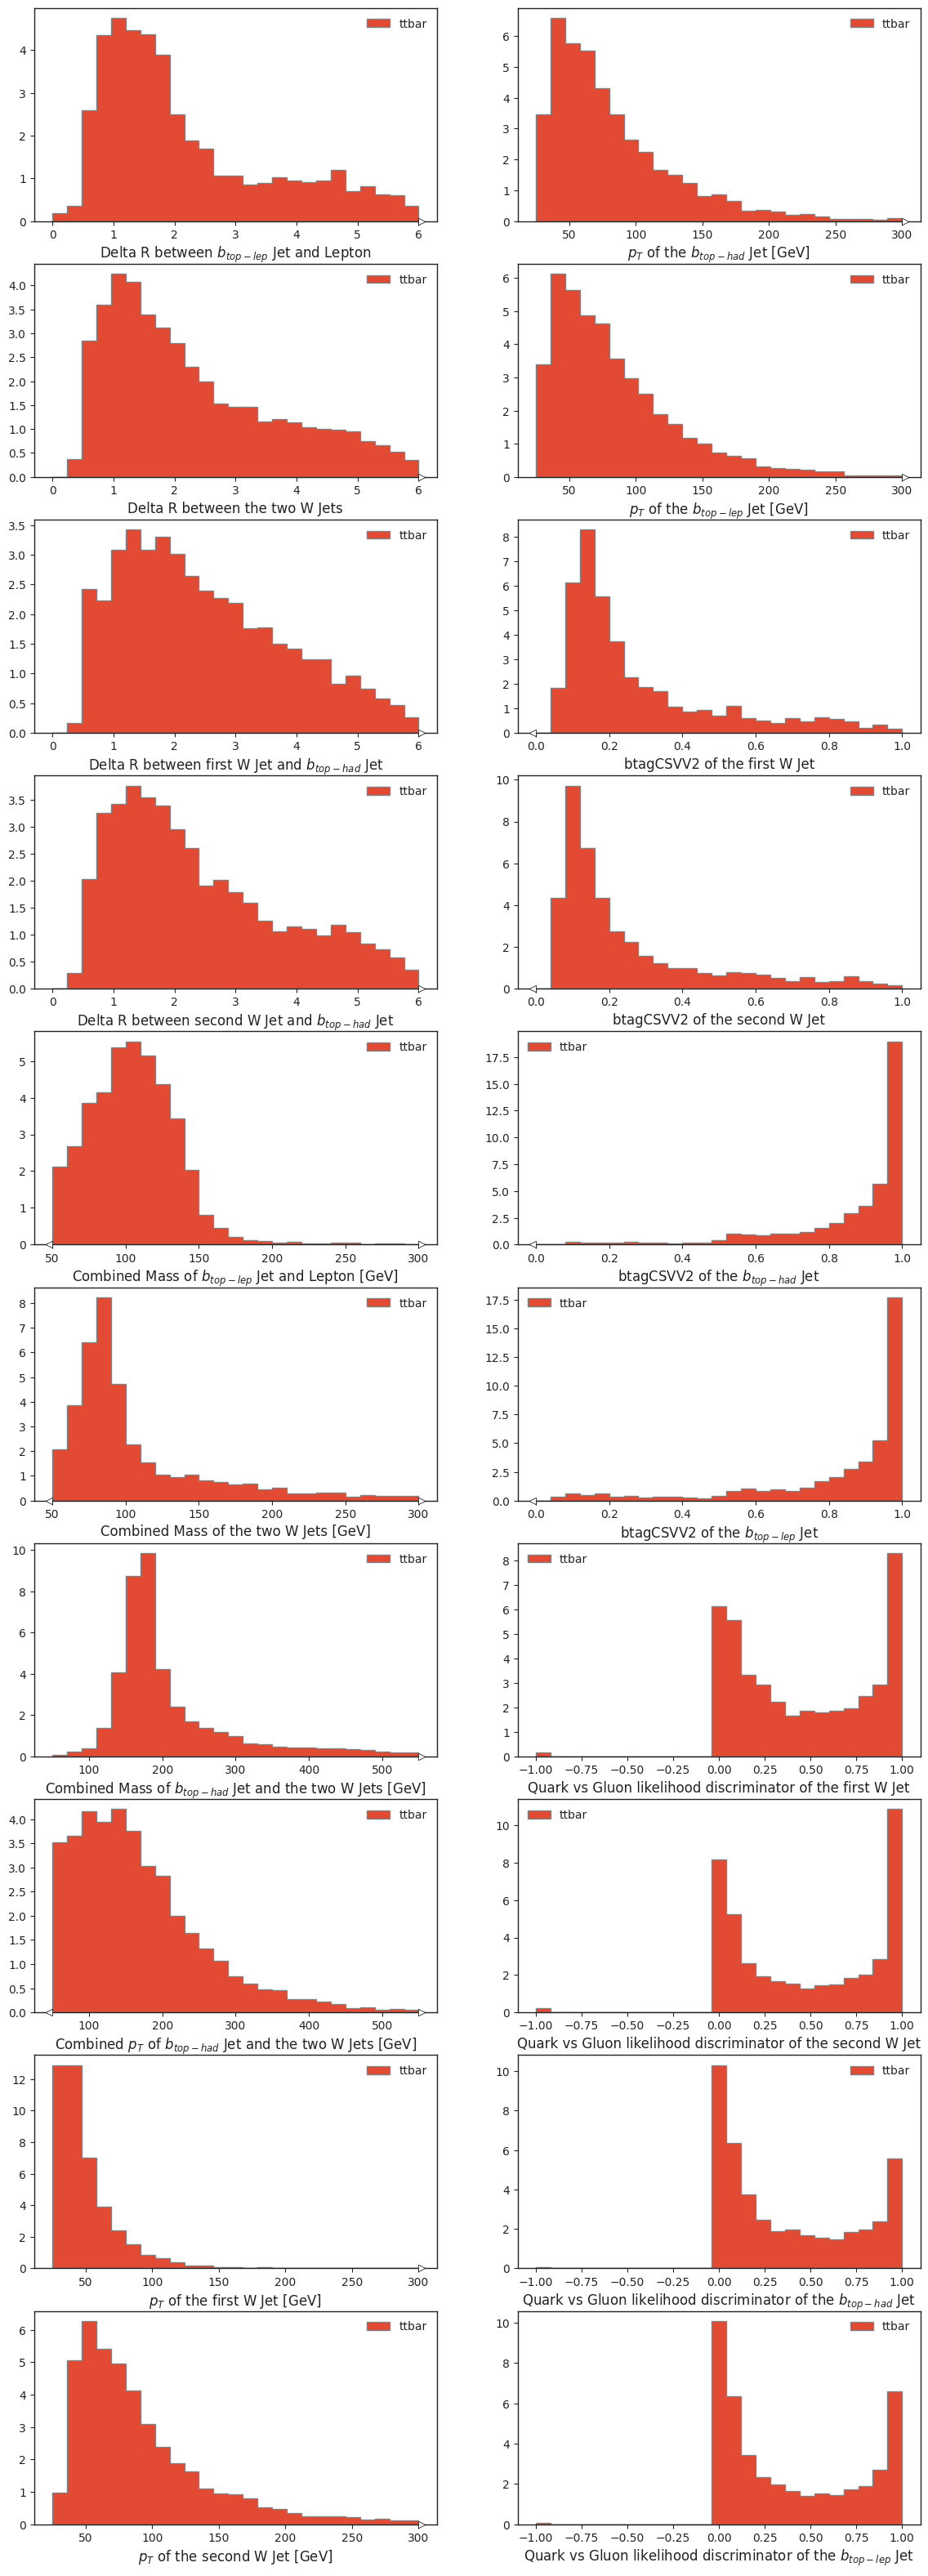

In [9]:
# ML inference variables
if USE_INFERENCE:
    fig, axs = plt.subplots(10, 2, figsize=(14, 40))
    for i in range(len(utils.config["ml"]["FEATURE_NAMES"])):
        if i < 10:
            column = 0
            row = i
        else:
            column = 1
            row = i - 10
        all_histograms["ml_hist_dict"][utils.config["ml"]["FEATURE_NAMES"][i]][:, :, "nominal"].stack(
            "process"
        ).project("observable").plot(
            stack=True,
            histtype="fill",
            linewidth=1,
            edgecolor="grey",
            ax=axs[row, column],
        )
        axs[row, column].legend(frameon=False)
    plt.show()